Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# Tower: 
## Análise da Resposta Dinâmica de Torres à Ação do Vento

---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Prof. Acir M. Loredo-Souza, Ph.D._ 

_Porto Alegre, RS, Brazil_ 

[![DOI](https://zenodo.org/badge/153307961.svg)](https://zenodo.org/badge/latestdoi/153307961)
___

[1 Introdução](#section_1)   
[2 Dados da torre utilizada como exemplo de análise](#section_2)   
[3 Fundamentos teóricos para o cálculo das forças aerodinâmicas](#section_3)   
[4 Resposta dinâmica por superposição modal](#section_4)   
[5 A força modal conforme a NBR-6123](#section_5)   
[6 Cálculo da resposta modal média e flutuante](#section_6)   
[7 Cálculo das amplitudes de deslocamento](#section_7)   
[8 Cálculo comparativo da resposta sem amplificação dinâmica](#section_8)   
[9 Forças estáticas equivalentes](#section_9)   
[10 Referências](#section_10)   


In [1]:
# Módulos Python necessários neste notebook:

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

# O módulo "Tower" contém algumas funções desenvolvidas especialmente para este notebook:

from Tower import *


## 1 Introdução <a name="section_1"></a> 

A metodologia de análise apresentada neste artigo corresponde ao método dinâmico apresentado no Capítulo 9 da NBR-6123. Faz-se uso dos mesmos modelos para a densidade espectral da velocidade do vento e para sua estrutura de correlação dependente da freqüência (função de coerência). 
A resposta dinâmica é calculada através do método de superposição modal, mas restringe-se aqui a resposta a um único modo de translação pura (sem torção).
Como muitas das fórmulas apresentadas a seguir incluem constantes físicas dimensionais, deve-se adotar estritamente o sistema internacional de unidades (SI).

O método do Capítulo 9 da NBR-6123 considera a disponibilidade de um modelo discreto da estrutura a ser analisada. O presente artigo inclui a preparação deste modelo, o cálculo de suas propriedades dinâmicas, o cálculo da resposta estrutural e, por fim, o cálculo das forças estáticas equivalentes a serem utilizadas no projeto.

<img src="resources/tower.png" alt="Tower" width="320px"/>

É importante lembrar que a norma impõe uma análise dinâmica para estruturas sujeitas à ação do vento cuja frequência fundamental de vibração livre esteja abaixo de 1Hz. 
Dependendo da massa posicionada na parte superior da torre, a frequência fundamental
pode ser afetada pelo efeito de segunda ordem devido à carga compressiva, o que
neste caso precisa ser devidamente considerado.


## 2 Dados da torre utilizada como exemplo de análise <a name="section_2"></a> 

Para os procedimentos de cálculo apresentados ao longo deste artigo será utilizada como exemplo uma torre metálica constituída de um tubo com seção circular variável, com segmentos emendados por traspasse, cujas propriedades estão dadas abaixo (carregadas de uma planilha Excel utilizando-se o módulo ```pandas```):

In [2]:
# Lê arquivo de dados com "pandas" e ajusta unidade

with open('resources/structure.xlsx', 'rb') as target:
    sheet =  pd.read_excel(target, sheet_name='data')
    data  =  sheet.values
    
z  =  data[:,0]              # coluna 1: cota vertical dos limites (m)
D  =  data[:,1]/1e2          # coluna 2: diâmetro externo nas cotas dadas (cm)
S  =  data[:,2]/1e4          # coluna 3: área da seção transversal (cm^2)
I  =  data[:,3]/1e8          # coluna 4: momento de inércia de área (cm^4)

H  =  z[0]                   # altura total da torre

# Média das duas extremidades para obter propriedades dos segmentos

zm = (z[:-1] + z[1:])/2      # cota média de cada segmento
Dm = (D[:-1] + D[1:])/2      # diâmetro externo médio de cada segmento
Sm = (S[:-1] + S[1:])/2      # seção transversal média de cada segmento
Im = (I[:-1] + I[1:])/2      # inércia de área média de cada segmento

NS =  len(zm)                # número de segmentos       

# Propriedades derivadas dos dados fornecidos

L  =  z[:-1] - z[1:]         # comprimento de cada segmento
M  =  7850*Sm*L              # massa de cada segmento
EI =  2.05e11*Im             # rigidez à flexão de cada segmento
IR =  M*L**2/12 + 7850*L*Im  # inércia rotacional do fuste
CA =  0.6*L*Dm               # área efetiva de arrasto (cilindro, vide gráfico)

# O seguinte artifício aproxima a solução estática com o método dinâmico,
# pois mantém a rigidez da estrutura aumentando sua frequência fundamental.
# Para fazer esta verificação, retirar o simbolo de comentário da linha abaixo:
# M = M/100                   


O coeficiente de arrasto definido para o fuste da torre foi obtido do gráfico abaixo:

<img src="resources/drag.png" alt="drag" width="640px"/>

Foi utilizado um número de Reynolds $ Re = 70000 V_k D \approx 2\times 10^6$, o que implica em $C_{\rm a} \approx 0.6$. Este coeficiente foi utilizado ao longo de todo o fuste na entrada de dados acima.


## 3 Fundamentos teóricos para o cálculo das forças aerodinâmicas <a name="section_3"></a> 

A força dinâmica exercida pelo vento em um segmento vertical de uma torre, com área de exposição, $A$,  e coeficiente de arrasto associado, $C_{\rm a}$, é uma função da altura em relação ao solo, $z$, e do tempo, $t$, dada (com unidades no SI) por:

$$F(z, t) = 0.613 V^2(z, t) C_{\rm{a}} A$$

A velocidade do vento, $V(z,t)$, pode ser decomposta em uma parcela média sobre 600 segundos (função de $z$), e uma parcela flutuante:

$$V(z, t) = \bar{V}(z) + v(z,t)$$

e consequentemente o seu quadrado resulta ser:

$$V^2(z, t) = \bar{V}^2(z) + 2\bar{V}(z)v(z,t) + v^2(z,t) \approx \bar{V}^2(z) + 2\bar{V}(z)v(t)$$

onde a aproximação acima é aceitável porque a parcela flutuante é relativamente menor que a parcela média e, portanto, $v^2(z,t) \approx 0$. A força aerodinâmica também pode ser dividida em uma parcela média e outra flutuante como:

$$F(z,t) = \bar{F}(z) + f(z, t)$$

onde:

\begin{align*}
\bar{F}(z) &= 0.613\bar{V}(z)^2 C_{\rm{a}} A \\
 f(z, t)   &= \frac{2\bar{F}(z)}{\bar{V}(z)}v(z, t)
\end{align*}

A NBR-6123 adota uma lei exponencial para o perfil de velocidade média do vento:

$$\bar{V}(z) = \left (S_1 S_3 V_0 \right ) b F_{\mathrm{r}} \left ( \frac{z}{10 \rm{m}} \right )^p$$

onde o termo $\left (S_1 S_3 V_0 \right )$ segue as definições da norma e os demais parâmetros necessários estão dados na tabela abaixo. <br><br>

<img src="resources/wind.png" alt="wind" width="800px"/>

Caso não houvesse amplificação dinâmica na resposta estrutural, poderia ser utilizado o cálculo estático da norma, aplicando-se diretamente forças médias com tempo de média, $T_{\rm gust}$, definido pela equação (NBR-6123, Anexo A, item 2):

$$T_{\rm{gust}} = \frac{7.5L} {\bar{V}_{T{\rm{, topo}}}}$$

onde $L$ é a maior dimensão, em metros, do plano de exposição ao vento (no caso de torres corresponde à altura exposta acima da superfície) e $\bar{V}_{T{\rm{, topo}}}$ é a velocidade média sobre $T_{\rm gust}$ no topo da estrutura. Nota-se que a equação acima exige uma iteração para seu cálculo, já que $\bar{V}_{T{\rm{, topo}}}$ é desconhecida _a priori_. Após a determinação de $T_{\rm gust}$ seria ainda necessária uma interpolação para se determinar os demais parâmetros da equação para $\bar{V}(z)$. Esta interpolação está disponível por meio da função ```profile``` do módulo ```Tower.py```, demonstrada a seguir.

Para o exemplo da torre a ser analisada tem-se os seguintes dados meteorológicos referentes à categoria de rugosidade II e velocidade básica $V_0 = 45{\rm m/s^2}$:

In [3]:
V0  =  45.0          # velocidade básica
S1  =  1.00          # fator topográfico
S3  =  1.00          # fator estatístico

# Parametros do perfil são obtidos por interpolação (módulo "Tower")

S2_10, b, p, Fr, z0, bt, ca = profile(10, Tav=600, Cat=2)  # fator S2 para 10m de altura

Vm_10 = S1*S3*S2_10*V0
sig_V = 2.58*Vm_10*np.sqrt(ca/1000)

print(' Vm_10 = {0:5.2f}m/s\n sig_V = {1:5.2f}m/s'.format(Vm_10, sig_V))


 Vm_10 = 31.05m/s
 sig_V =  6.46m/s


O cálculo do tempo de rajada para a análise estática, $T_{\rm gust}$, bem como da correspondente velocidade média no topo é feito por um processo iterativo:

In [4]:
Tgust = 3     # valor inicial do tempo de média

print('Convergência da iteração... \n')

for ii in range(3):
    S2, *garb = profile(50, Tav=Tgust, Cat=2)
    
    VmT   = S1*S2*S3*V0
    Tgust = 7.5*H/VmT

    print('Tgust = {0:4.2f}s, VmT = {1:5.1f}m/s'.format(Tgust, VmT))


Convergência da iteração... 

Tgust = 7.27s, VmT =  51.6m/s
Tgust = 7.41s, VmT =  50.6m/s
Tgust = 7.41s, VmT =  50.6m/s


Caso a avaliação da resposta dinâmica se faça de fato necessária (frequência fundamental inferior a 1Hz), as duas parcelas na equação para $V(z,t)$ devem ser consideradas. Neste caso, a abordagem matemática mais conveniente é a passagem das equações do domínio do tempo para o domínio da frequência, onde se faz uso de espectros de potência para caracterizar as parcelas flutuantes da velocidade do vento e das respectivas forças. Note-se que ao se desprezar o termo $v^2(z,t)$ permitiu-se uma proporcionalidade direta entre os espectros de potência das parcelas flutuantes de força e velocidade, que pode então ser expressa como:

$$ S_f(z, f) = \left [ \chi_{\mathrm{A}}(f) \; 
               \frac{2\bar{F}(z)}{\bar{V}(z)} \right ]^2 S_v(z, f)$$

onde $f$ é a frequência (variável independente no novo domínio de análise, em Hz), e $\chi_{\rm{A}}(f)$ é a chamada _função de admitância aerodinâmica_. Esta função, que varia de 1 a 0 de forma decrescente com a frequência, pode ser entendida como uma correção no coeficiente de arrasto implícito em $\bar{F}(z)$ e considera que flutuações rápidas na velocidade do vento não implicam em flutuações proporcionais na força aerodinâmica sobre todo o perímetro da estrutura a uma dada altura. Caso se desconsidere a função de admitância, fazendo-se $\chi_{\rm{A}}(f) = 1$, está-se adotando uma simplificação conservadora. 

Para as flutuações da componente longitudinal da velocidade do vento a NBR-6123 adota o chamado espectro de Harris, que é independente da altura acima da superfície:

$$\frac{S_v(f)}{\sigma_v^2 } = \frac{0.61 X}{\left [ 2 + (fX)^2 \right ] ^{5/6}}$$

onde a constante $X$ é dada por:

$$X = \frac{1800}{\bar{V}_{10{\rm{m}}}}$$

sendo que $\bar{V}_{10\rm{m}}$ é a velocidade média sobre 600s na altura de referência,  $z = 10\rm{m}$. No modelo de Harris a variância da velocidade do vento, $\sigma_v^2$, é considerada como sendo aproximadamente independente da altura, e estimada por:

$$\sigma_v = 2.58 \bar{V}_{10{\rm{m}}}\sqrt{c_{\rm{as}}}$$

onde $c_{\rm{as}}$ é um coeficiente de arrasto superficial adimensional, dependente da categoria de rugosidade do terreno conforme apresentado na tabela acima. 

O gráfico do espectro de velocidade de Harris para a torre em questão, que é independente da coordenada vertical $z$, pode ser visualizado abaixo:

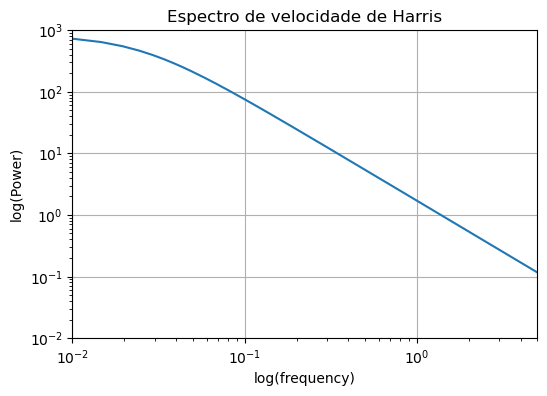

In [5]:
Nf = 1024                       # número de pontos do espectro
fp = 5.                         # frequência máxima
df = fp/Nf                      # resolução da frequência

f  = np.linspace(0, fp, Nf)     # domínio da frequência (Hz)
X  = 1800/Vm_10

SV = 0.61*X*(sig_V**2)/(2 + f*f*X*X)**(5/6)

plt.figure(1, figsize=(6,4))
plt.loglog(f, SV)
plt.axis([0.01, fp, 0.01, 1000])
plt.title('Espectro de velocidade de Harris')
plt.xlabel('log(frequency)')
plt.ylabel('log(Power)')
plt.grid(True)


Deve ser observado que a integral da densidade espectral corresponde, por definição, à variância da parcela flutuante da velocidade do vento:

In [6]:
sV2 = np.trapz(SV, dx=df)

print(' sig_V spectrum:  {0:5.2f}m/s\n sig_V specified: {1:5.2f}m/s'.format(np.sqrt(sV2), sig_V))


 sig_V spectrum:   6.45m/s
 sig_V specified:  6.46m/s


## 4 Resposta dinâmica por superposição modal <a name="section_4"></a> 

A resposta dinâmica de um sistema estrutural linear elástico (ou linearizado no entorno de uma dada resposta média) pode ser calculada a partir da equação diferencial de equilíbrio dinâmico:

$${\bf M} \ddot{\vec{u}} + {\bf C} \dot{\vec{u}} + {\bf K} \vec{u} = \vec{F}(t)$$

onde ${\bf M}$ é a matriz de massa, ${\bf C}$ é a matriz de amortecimento (viscoso, ou Newtoniano), ${\bf K}$ é a matriz de rigidez, $\vec{u}$ é o vetor de deslocamentos generalizados, e $\vec{F}(t)$ é o vetor de forças externas generalizadas. 
Considerando-se que as forças de amortecimento são pequenas e que não há forças externas atuantes, tem-se a equação de equilíbrio em vibração livre:

$${\bf M} \ddot{\vec{u}} + {\bf K} \vec{u} = \vec{0}$$

para a qual se admite a solução:

$$\vec{u}(t) = u_k(t) \; \vec \phi_k$$

ou seja, a resposta é composta de uma função escalar do tempo e um vetor de constantes adimensionais. Admitindo-se que em vibração livre não-amortecida os deslocamentos são funções sinusoidais do tempo:

$$u_k(t) = u_{k, {\rm max}} \cos \omega_k t$$

e substituindo-se esta expressão na equação de equilíbrio chega-se a:

$${\bf K} \vec \phi_k = \omega_k^2 {\bf M} \vec \phi_k$$

que resulta ser um _problema de autovalores-autovetores_ com tantas soluções  quanto o número de graus de liberdade, $n$, do modelo estrutural. As frequências $\omega_k$ são denominadas _frequências naturais de vibração livre_ e os vetores $\vec \phi_k$ são denominados _formas modais_, com o sub-índice $k$ denotando o _modo de vibração_. 

Por se tratar de um sistema linear (ou linearizado), a equação de equilíbrio dinâmico pode ser resolvida por um método denominado superposição modal, sendo que a resposta total é obtida através da soma das respostas em cada modo de vibração. Subtituindo-se a $\vec{u}(t)$ na equação de equilíbrio e pré-multiplicando-se todos os termos por $\vec\phi_k^{\; \rm T}$ (com o $\rm T$ denotando _transposição_) tem-se:

$$
(\vec\phi_k^{\; \rm T}{\bf M} \vec\phi_k) \, \ddot{u}_k + 
(\vec\phi_k^{\; \rm T}{\bf C}  \vec\phi_k) \, \dot{u}_k + 
(\vec\phi_k^{\; \rm T}{\bf K}  \vec\phi_k) \,  u_k = \vec\phi_k^{\; \rm T} \vec{F}(t)
$$

Devido à propriedade de ortogonalidade dos autovetores $\vec \phi_k$, e desde que a matriz de amortecimento, ${\bf C}$, possa ser representada como uma combinação linear das matrizes ${\bf M}$ e ${\bf K}$ (denominada _matriz de amortecimento proporcional_, ou de Rayleigh), todos os termos da equação acima resultam escalares e pode-se escrever:

$$M_k \ddot{u}_k + C_k \dot{u}_k + K_k  u_k = F_k(t)$$

onde $M_k$, $C_k$, $K_k$ e $u_k(t)$ são denominados _massa, amortecimento, rigidez e resposta modais_, respectivamente. Deve-se dar um destaque especial à chamada _força modal_:

$$F_k(t) = \vec\phi_k^{\; \rm T} \vec{F}(t)$$

já que o método de análise dinâmica da NBR-6123 traz implícito um espectro de potência para esta função escalar do tempo, que será apresentado na próxima seção. 

A solução da equação de equilíbrio dinâmico por meio de superposição modal implica que uma única equação matricial é substituída por $n$ equações escalares acima, com $k = 1, 2, \dots, n$. 
A resposta total do sistema é dada pela superposição de todas as respostas modais:

$$\vec{u}(t) =  \sum_{k = 1}^n  \;  u_k(t)  \; \vec \phi_k$$

A grande vantagem da solução por superposição modal está na evidência de que o somatório na equação acima pode ser truncado para um número de termos muito menor que o número total de graus de liberdade. Para torres esbeltas submetidas à ação do vento, o número de modos que precisam ser considerados na solução  é geralmente apenas 1, no máximo 2. Este truncamento implica que o modelo estrutural pode ser satisfatoriamente caracterizado por uns poucos conjuntos de propriedades ($M_k$, $K_k$, $\vec \phi_k$) e alguma regra para definição do amortecimento, $C_k$. 

É importante observar que as formas modais, $\vec \phi_k$, tem escala (normalização) arbitrária, a qual deve ser claramente definida e consistentemente mantida durante todas as etapas da análise. É conveniente adotar-se uma normalização pela matriz de massa, tal que:

$$M_k = \vec\phi_k^{\; \rm T} {\bf M} \vec\phi_k = 1$$

que tem a vantagem de evitar problemas de ordem de grandeza nos parâmetros da equação de equilíbrio modal. Aplicando-se esta normalização tem-se a forma alternativa da equação de equilíbrio dinâmico:

$$\ddot{u}_k + 2\zeta_k \omega_k \dot{u}_k + \omega_k^2  u_k = F_k(t)$$

onde $\zeta_k$ é um parâmetro muito importante denominado _razão de amortecimento crítico_ no $k$-ésimo modo. Por ser adimensional, $\zeta_k$ é muito mais conveniente para definir níveis de amortecimento do que a constante $C_k$ (que pode ter, por exemplo, unidade Ns/m). Para estruturas de Engenharia Civil (pontes, edifícios, torres, pisos), em geral, a razão de amortecimento situa-se entre 0.005 e 0.03. Para torres metálicas aparafusadas é recomendável adotar-se $\zeta_k$ = 0.01. 

Para a torre do exemplo, a montagem das matrizes do sistema e a solução do problema de autovalores é feita como descrito abaixo. Deve-se observar que cada nó estrutural tem dois graus de liberdade, o primeiro de translação e o segundo de rotação:

<table>
 <tr>
   <td><img src="resources/discretization.png" alt="Discretization" width="280px"/></td>
   <td><img src="resources/element.png"        alt="Finite element" width="280px"/></td>
 </tr>
</table> 


In [7]:
a = np.array([[1,2,3,4],[5,6,7,8]]).T

print(a.reshape(2*4))

[1 5 2 6 3 7 4 8]


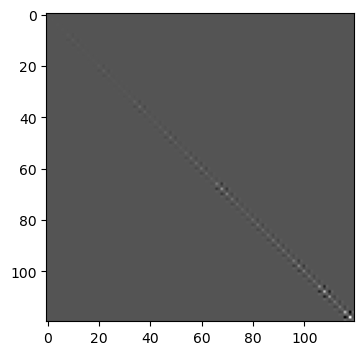

In [8]:
# Montagem da matriz de rigidez global

KG = stiffness(L, EI)   # matriz completa (módulo "Tower")
KG = KG[:-2,:-2]        # último nó (base) tem deslocamentos impedidos

# Montagem da matriz de massa global (tipo "lumped", matriz diagonal)

MG = np.diag(np.vstack((M, IR)).T.reshape(2*NS) )

# Solução do problema de autovalores com o módulo scipy

import scipy.linalg as sc
w2, Phi  =  sc.eig(KG, MG)

# Impõe ordem crescente dos modos
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Converte autovalores em frequências
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

# Normaliza formas modais pela matriz de massa
# (portanto, a partir daqui a massa modal é unitária)
for k in range(len(wk)):
    
    Mk       = np.sum(np.diag(MG)*Phi[:,k]*Phi[:,k])
    Phi[:,k] = Phi[:,k]/np.sqrt(Mk)
    
    if (Phi[0,k] < 0): Phi[:,k] *= -1   # impõe sinal positivo no topo

# Visualização da matriz de rigidez    
plt.figure(2, figsize=(4,4))
kh = plt.imshow(KG, cmap=plt.cm.gray)


Os três primeiros modos de vibração da torre são visualizados abaixo, sendo que a escala dos modos é reajustada para que a máxima amplitude seja unitária (apenas para os gráficos):

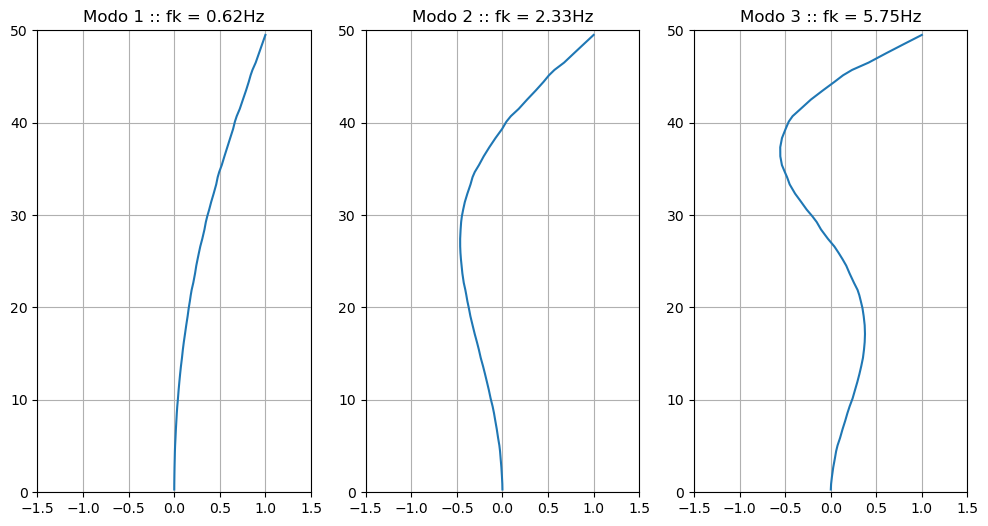

In [9]:
plt.figure(2, figsize=(12,6))

for k in range(3):
    
    pk = Phi[0:-1:2,k]        # retem somente a translação
    pm = pk[0]                # normaliza máxima amplitude unitária
    
    plt.subplot(1,3,k+1)
    plt.plot(pk/pm, zm)
    plt.axis([-1.5, 1.5, 0, H])
    plt.title('Modo {0} :: fk = {1:4.2f}Hz'.format(k+1,fk[k]))
    plt.grid(True)


Para o restante da análise serão retidos apenas os graus de liberdade de translação no primeiro modo:

In [10]:
pk1 = Phi[0:-1:2,0]
wk1 = wk[0]
fk1 = fk[0]


## 5 A força modal conforme a NBR-6123 <a name="section_5"></a> 

Sem perda de generalidade, é possível adotar a convenção de que os $n$ graus de liberdade do sistema estrutural correspondem aos deslocamentos horizontais na direção do vento, coincidindo assim com $n$ pontos de aplicação das forças aerodinâmicas, cada ponto correspondendo a uma cota vertical $z_i$, com $i = 1, 2, \dots, n$. Neste caso, as forças aerodinâmicas são discretizadas como:

$$F(z_i,t) = F_i(t) = \bar{F}_i + f_i(t)$$

A partir desta convenção, a força modal pode ser calculada através de um simples somatório:

$$F_k(t) = \vec\phi_k^{\; \rm T} \vec{F}(t) = \sum_{i = 1}^n \phi_{ik} F_i(t)$$

O método da superposição modal é válido tanto para a parcela média como para a parcela flutuante da força modal. Isto significa que o método também fornece a parte estática da resposta estrutura, e torna-se assim conveniente decompor também a força modal em parcelas estáticas e flutuantes:

$$F_k(t) =  \bar{F}_k + f_k(t)$$

Admitindo-se que a força modal é um processo aleatório ergódico e estacionário, e considerando-se que a variância de uma soma é igual à soma cruzada das covariâncias, tem-se o espectro da _parcela flutuante_ força modal:

$$S_{f_k}(f) = \sum_{i = 1}^n \sum_{j = 1}^n \phi_{ik} \phi_{jk} S_{f_i f_j} (f)$$

onde $S_{f_i f_j}(f)$ é o espectro cruzado (análogo à covariância) entre as parcelas flutuantes das forças atuantes no graus de liberdade $i$ e $j$, que é modelado através dos espectros marginais e de uma função de coerência, $R_{ij} (z_i, z_j,f)$:

$$S_{f_i f_j} (f) = R_{ij} (z_i, z_j, f) \sqrt{S_{f} (z_i,f) S_{f} (z_j, f)}$$

A função de coerência utilizada na NBR-6123 tem a forma:

$$R_{ij} (z_i, z_j, f) = \exp\left [ -C \;\; \frac{f \Delta z_{ij}}{\bar{V}_{10{\rm{m}}}} \left ( \frac{\bar{z}_{ij}}{10{\rm{m}}} \right )^\gamma \right ]$$

com $C = 10$, $\gamma = -0.3$, e onde:

\begin{align*}
\Delta z_{ij} &= |z_i - z_j| \\
\bar{z}_{ij}  &= \frac{1}{2} (z_i + z_j)
\end{align*}

são a diferença de altura e a altura média dos graus de liberdade $i$ e $j$, respectivamente. É importante observar que forças $f_i(t)$ e $f_j(t)$ perfeitamente correlacionadas estariam associadas a uma função de coerência constante unitária, o que simplificaria a análise mas conduziria a uma maior variância para a força modal, e consequentemente a um projeto antieconômico. Portanto, uma função de coerência que corretamente represente as características da turbulência atmosférica é muito relevante para uma análise mais realista e econômica.

Fazendo-se uso as equações anteriores, obtem-se para a parcela média:

$$\bar{F}_k = 0.613 \left ( C_{\rm{a}} A \right )  
                    \left ( b F_{\rm{r}}S_1 S_3 V_0 \right )^2 
                    \sum_{i = 1}^n \phi_{ik} \left (\frac{z_i}{10 {\mathrm{m}}} \right )^{2p}$$

Da mesma forma, o espectro da parcela flutuante da força modal resulta ser:

$$S_{f_k}(f) = 4 S_v(f) \sum_{i = 1}^n \sum_{j = 1}^n 
               \left [ \frac{\phi_{ik} \bar{F}(z_i)}{\bar{V}(z_i)} \right ]
               \left [ \frac{\phi_{jk} \bar{F}(z_j)}{\bar{V}(z_j)} \right ] R_{ij} (z_i, z_j, f)$$

onde o espectro da velocidade pode ser fatorado do somatório por não depender das cotas $z_i$ ou $z_j$. 

Deve ser observado que a determinação deste espectro é computacionalmente custosa, e algumas medidas devem ser tomadas para aumentar sua eficiência. O procedimento é ilustrado a seguir para a torre do exemplo de análise.


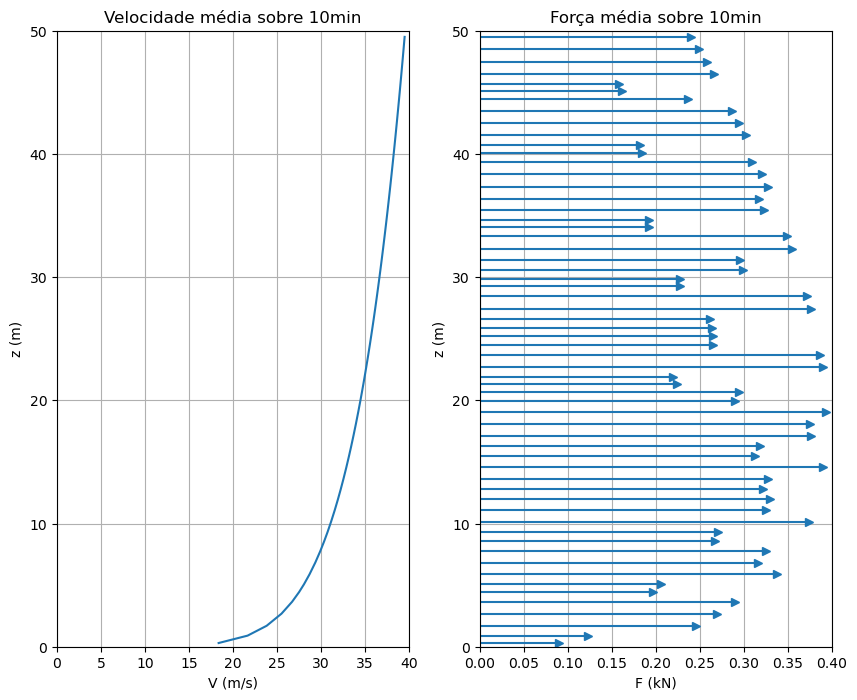

In [11]:
# Utiliza o módulo "Tower" para calcular o perfil médio
S2, *garb = profile(zm, Tav=600, Cat=2)

# Velocidades e forças de arrasto médias sobre 10min
Vm = S1*S2*S3*V0
Fm = 0.613*(Vm**2)*CA

# Visualiza perfis
plt.figure(3, figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(Vm, zm)
plt.axis([0, 40, 0, H])
plt.title('Velocidade média sobre 10min')
plt.xlabel('V (m/s)')
plt.ylabel('z (m)')
plt.grid(True)

plt.subplot(1,2,2)
plt.errorbar(Fm/1000, zm, xerr=[Fm/1000, 0*Fm], fmt='>')
#plt.plot(Fm/1000, zm)
plt.axis([0, 0.4, 0, H])
plt.title('Força média sobre 10min')
plt.xlabel('F (kN)')
plt.ylabel('z (m)')
plt.grid(True)


A força modal média é obtida do produto interno com a forma modal:

In [12]:
Fmk = np.sum(pk1*Fm); 

print('Força modal média: {0:5.1f}N.'.format(Fmk))

Força modal média: 205.8N.


O valor da força modal média está relacionado com a escala da forma modal, e não deve ser avaliado pelo seu valor absoluto. Ele será usado para calcular a resposta média do deslocamento e essa sim terá um significado físico claro.

Já o cálculo do espectro da parcela flutuante da força modal demanda um algoritmo mais elaborado, de modo a tornar eficiente o duplo somatório envolvendo a função de coerência. Abaixo está o procedimento com comentários.

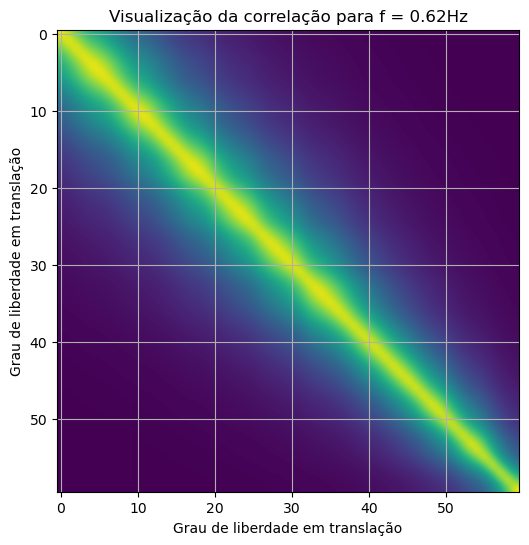

In [13]:
# Prepara os termos cruzados do somatório
zi, zj =  np.meshgrid(zm,zm)

dz  =  np.abs(zi - zj)
zij = (zi + zj)/2

# Fatorando f da função de coerência
R0  =  np.exp(-10*(dz/Vm_10)*(zij/10)**(-0.3))

# Visualiza autocorrelação espacial
plt.figure(4, figsize=(8,6))

plt.imshow(R0**fk1, interpolation='bicubic')
plt.title('Visualização da correlação para f = {0:4.2f}Hz'.format(fk1))
plt.xlabel('Grau de liberdade em translação')
plt.ylabel('Grau de liberdade em translação')
plt.grid(True)


No loop abaixo, o somatório é substituído por uma operação matricial, bem mais rápida, e o espectro da força modal é calculado para todo o domínio da frequência:

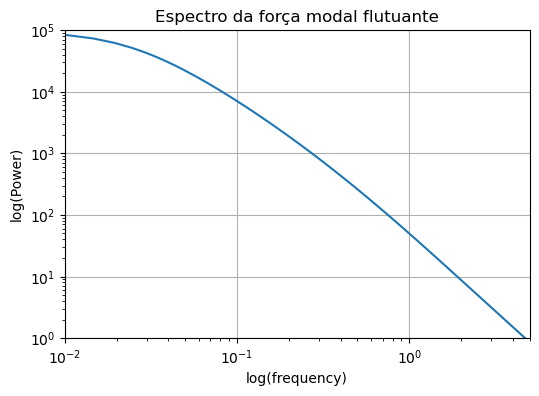

In [14]:
# Reseta espectro e prepara constantes internas
Sfk  =  np.zeros(Nf)   
qF   =  2*pk1*Fm/Vm

# Prepara operação matricial
Rij  =  R0**df;        
dRij =  Rij.copy();

# Loop sobre o domínio da frequência
for k in range(Nf):
    Rij   *= dRij
    Sfk[k] = np.dot(np.dot(qF,Rij),qF);

# Multiplicação final pelo espectro da velocidade
Sfk *= SV

#Visualiza espectro da força modal
plt.figure(5, figsize=(6,4))
plt.loglog(f, Sfk)
plt.axis([0.01, fp, 1e0, 1e5])
plt.title('Espectro da força modal flutuante')
plt.xlabel('log(frequency)')
plt.ylabel('log(Power)')
plt.grid(True)


## 6 Cálculo da resposta modal média e flutuante <a name="section_6"></a> 

Uma vez determinada a força modal média, a resposta modal média é facilmente obtida através da rigidez modal com a expressão:

$$ \bar{u}_k = \frac{\bar{F}_k}{K_k}$$

onde $K_k = \omega_k^2 M_k$, ou apenas $K_k = \omega_k^2$ caso a normalização das formas modais pela matriz de massa tenha sido adotada.

Já o espectro da resposta modal flutuante deve ser obtido através da admitância mecânica, definida para sistemas com um grau de liberdade como:

$$\lvert H(f) \rvert ^2 = \frac{1}{K_k^2 \left [ 
                                         \left ( 1 - \beta^2 \right )^2 + 
                                         \left ( 2 \zeta_k \beta \right )^2
                                         \right ]}$$

onde $\beta = f \; / \; f_k$ é a frequência adimensionalizada e $\zeta_k$ é o amortecimento modal (razão do crítico). Assim, o espectro da parcela flutuante da resposta modal é dado por:

$$ S_{u_k}(f) = \lvert H(f) \rvert ^2  S_{f_k}(f) $$

Abaixo estão demonstrados estes cálculos para a torre do exemplo de aplicação.


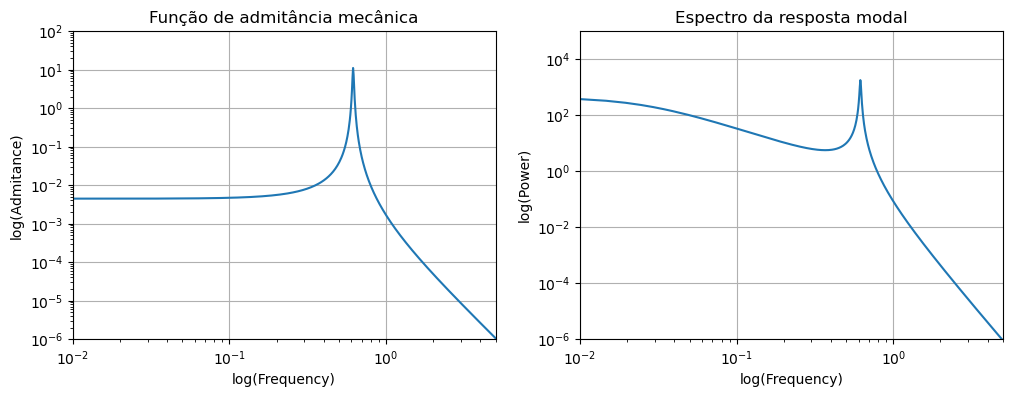

In [15]:
zk  =  0.01        # amortecimento modal
bt  =  f/fk1       # frequência adimensionalizada
Kk  =  wk1*wk1     # rigidez modal (massa modal unitária)
umk =  Fmk/Kk      # resposta modal média

# Determina admitância mecânica e calcula resposta
Hf2 =  1/(Kk*Kk*((1 - bt**2)**2 + (2*zk*bt)**2))
Suk =  Hf2*Sfk

# Visualiza no domínio da frequência

plt.figure(6, figsize=(12,4))

plt.subplot(1,2,1)
plt.loglog(f, Hf2)
plt.axis([0.01, fp, 1e-6, 1e2])
plt.title('Função de admitância mecânica')
plt.xlabel('log(Frequency)')
plt.ylabel('log(Admitance)')
plt.grid(True)

plt.subplot(1,2,2)
plt.loglog(f, Suk)
plt.axis([0.01, fp, 1e-6, 1e5])
plt.title('Espectro da resposta modal')
plt.xlabel('log(Frequency)')
plt.ylabel('log(Power)')
plt.grid(True)


## 7 Cálculo das amplitudes de deslocamento <a name="section_7"></a> 

Até este ponto tem-se a média da resposta modal e o espectro da sua parcela flutuante. O deslocamento real médio é obtido do produto:

$$\vec{u}_{\rm med} =  \sum_{k = 1}^n  \;  \bar{u}_k  \; \vec \phi_k$$

Para a torre do exemplo tem-se:

In [16]:
um = umk*pk1

print('Máximo deslocamento médio: {0:5.3f}m'.format(np.max(np.abs(um))))


Máximo deslocamento médio: 0.522m


Observa-se que o resultado acima é aproximado, já que apenas um modo de vibração foi retido. O resultado mais preciso deve ser obtido diretamente com a matriz de rigidez global e o vetor de forças médias:

$${\bf K} \vec{u}_{\rm med} = \vec{F}_{\rm med}$$

que no exemplo dado resulta em:

In [17]:
# Preenchendo com zeros os momentos nos g.d.l. de rotação
FmG = np.vstack((Fm, np.zeros(Fm.shape))).T.reshape(2*NS)

# Resolvendo o sistema
um  = np.linalg.solve(KG, FmG)[0:-1:2]

print('Máximo deslocamento médio: {0:5.3f}m'.format(np.max(np.abs(um))))


Máximo deslocamento médio: 0.505m


Ou seja, a consideração de apenas 1 modo de vibração é bastante precisa para o exemplo, com um erro da ordem de 3%.

Para a parcela flutuante da resposta em deslocamento, como a análise foi conduzida no domínio da frequência, resultados no domínio do tempo só pode ser obtidos em termos estatísticos. A abordagem da NBR-6123 consiste em se adotar um fator de pico da resposta modal $g_k = 4$, aplicado sobre o desvio padrão da resposta flutuante.
No entanto, já que o espectro da resposta está disponível, é possível obter-se uma estimativa mais precisa deste fator de pico utilizando-se a fórmula de Davenport:

$$g_k = \sqrt{2 \ln (\nu_k T)} + \frac{0.5772}{\sqrt{2 \ln (\nu_k T)}}$$

onde $T$ é o tempo de observação, adotado como 600s na NBR-6123, e $\nu_k$ é a taxa de cruzamento do nível zero para o positivo (_zero upcrossing rate_), calculada a partir do espectro como:

$$ \nu_k = \sqrt{\frac{\int_0^\infty{f^2 S_{u_k}(f) \; df}}
                    {\int_0^\infty{    S_{u_k}(f) \; df}}} $$

Observe-se que o denominador dentro da raiz é a variância da resposta modal. 

Aplicando-se as expressões acima ao exemplo de cálculo tem-se:

In [18]:
suk2 = np.trapz(    Suk, dx=df)
suk4 = np.trapz(f*f*Suk, dx=df)

suk  = np.sqrt(suk2)
nuk  = np.sqrt(suk4/suk2)
lnu  = np.sqrt(2*np.log(600*nuk))
gpk  = lnu + 0.5772/lnu

print(' rms for modal response: {0:4.2f}m '.format(suk))
print(' Zero upcrossing nu_k:   {0:4.2f}Hz'.format(nuk))
print(' Peak factor g_k:        {0:4.2f}  '.format(gpk))


 rms for modal response: 7.28m 
 Zero upcrossing nu_k:   0.50Hz
 Peak factor g_k:        3.55  


Notes-se que a taxa de _upcrossing_ geralmente resulta em um valor próximo à frequência fundamental, enquanto o fator de pico obtido do espectro permite uma pequena economia em relação ao valor genérico adotado na norma.

Estes resultados permitem, finalmente, a determinação das amplitudes de resposta fazendo-se:


$$\vec{u}_{\rm max} =  \vec{u}_{\rm med} + \sum_{k = 1}^n  g_k \, \sigma_{u_k}  \; \vec \phi_k$$

O cálculo destes deslocamentos para o exemplo da torre está apresentado abaixo:

Deslocamento r.m.s.:        0.28m
Máximo deslocamento total:  1.26m


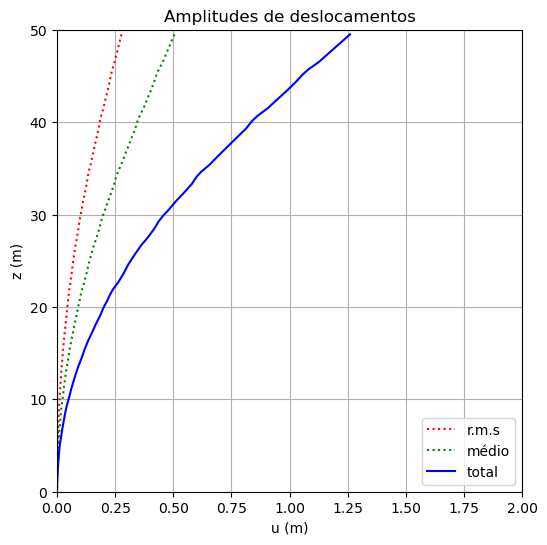

In [19]:
us = suk*pk1      # vetor de deslocamentos rms
up = gpk*us       # vetor de deslocamentos de pico
ut = us + up      # vetor de deslocamentos totais

print('Deslocamento r.m.s.:       {0:5.2f}m'.format(np.max(us)))
print('Máximo deslocamento total: {0:5.2f}m'.format(np.max(np.abs(ut))))

# Visualiza perfis
plt.figure(7, figsize=(6,6))

plt.plot(us, zm, 'r:')
plt.plot(um, zm, 'g:')
plt.plot(ut, zm, 'b')
plt.axis([0, 2, 0, H])
plt.title('Amplitudes de deslocamentos')
plt.legend(('r.m.s','médio','total'), loc=4)
plt.xlabel('u (m)')
plt.ylabel('z (m)')
plt.grid(True)


## 8 Cálculo comparativo da resposta sem amplificação dinâmica <a name="section_8"></a> 

Para fins de comparação, é interessante fazer o cálculo das amplitudes de deslocamento com a abordagem puramente estática, utilizando-se a velocidade de rajada ${\bar{V}_{T{\rm{, topo}}}}$ média sobre $T_{\rm{gust}}$ anteriormente calculada.

Para o exemplo dado o cálculo é apresentado abaixo.


In [20]:
# Força média sobre T_gust
FmT  = 0.613*(VmT**2)*CA

# Preenchendo com zeros os momentos nos g.d.l. de rotação
FTG  = np.vstack((FmT, np.zeros(FmT.shape))).T.reshape(2*NS)

# Resolvendo o sistema e retendo-se apenas a translação
umT  = np.linalg.solve(KG, FTG)[0:-1:2]

print('Máximo deslocamento estático: {0:4.2f}m'.format(np.max(np.abs(umT))))


Máximo deslocamento estático: 0.92m


Observa-se, portanto, que a amplificação dinâmica (ressonância) produziu um acréscimo de 25% sobre o deslocamento obtido do cálculo puramente estático.

## 9 Forças estáticas equivalentes <a name="section_9"></a> 

Forças estáticas equivalentes consistem em um vetor de cargas que, estaticamente aplicado, produz uma amplitude de deslocamento equivalente ao pico da resposta dinâmica. Em outras palavras, é um conjunto de forças fictícias que produz uma resposta estrutural real, e consequentemente um estado de tensões e deformações que poderá de fato ocorrer na estrutura. A determinação das forças estáticas equivalentes facilita a consideração dos efeitos dinâmicos no dimensionamento da estrutura.
Seu cálculo é feito a partir do vetor de deslocamentos de pico:

$$\vec{F}_{\rm eq} = {\bf K} \vec{u}_{\rm max} $$

Alternativamente, pode-se substituir a matriz de rigidez nesta equação fazendo-se uso da expressão do problema de autovalores-autovetores:

$${\bf K} \vec \phi_k = \omega_k^2 {\bf M} \vec \phi_k$$

Assim, a contribuição do $k$-ésimo modo ao vetor de forças resulta:

$$\vec{F}_{{\rm eq,}k} = \omega_k^2 u_{k, \rm max} {\bf M} \vec \phi_k $$

Caso seja necessária a consideração de mais de um modo de vibração no cálculo dos deslocamentos, surge o problema da combinação de respostas modais. Uma possível solução é o uso do critério de _combinação quadrática completa_ (CQC), normalmente utilizado em análise sísmica. Contudo, para o caso de torres esbeltas, a determinação das forças equivalentes utilizado-se apenas um modo apresenta, geralmente, uma precisão satisfatória.

Abaixo está demonstrado o cálculo das forças estáticas equivalentes para a torre do exemplo, comparando-se a solução com matriz de rigidez ou considerando-se apenas o primeiro modo:


Máximo deslocamento original:             1.26m
Máximo deslocamento equivalente (matriz): 1.26m
Máximo deslocamento equivalente (modo 1): 1.51m


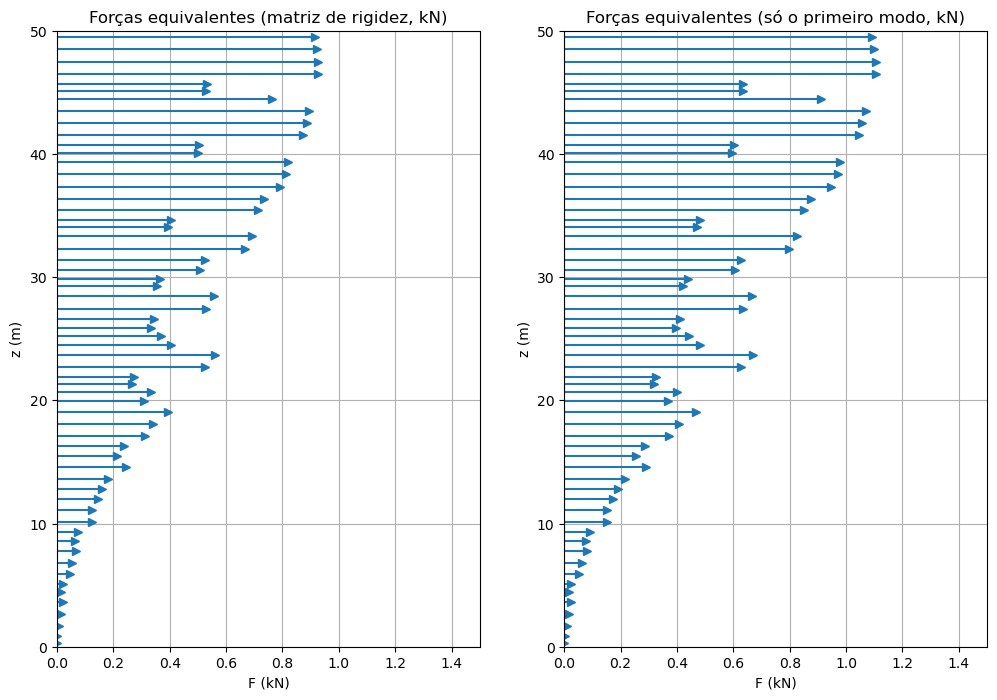

In [21]:
usG  =  suk*Phi[:,0]      # vetor de deslocamentos rms (todos os g.d.l.)
upG  =  gpk*usG           # vetor de deslocamentos de pico
utG  =  usG + upG         # vetor de deslocamentos totais

print('Máximo deslocamento original:             {0:4.2f}m'.format(np.max(np.abs(utG))))

# Solução com a matriz de rigidez global, verifica resultado
Feq1 =  np.dot(KG,utG)
ueq1  = np.linalg.solve(KG, Feq1)[0:-1:2]

print('Máximo deslocamento equivalente (matriz): {0:4.2f}m'.format(np.max(np.abs(ueq1))))

# Solução retendo só o primeiro modo de vibração
Feq2 =  wk1*wk1*(umk + gpk*suk)*np.dot(MG,Phi[:,0])
ueq2  = np.linalg.solve(KG, Feq2)[0:-1:2]

print('Máximo deslocamento equivalente (modo 1): {0:4.2f}m'.format(np.max(np.abs(ueq2))))

# Retem só os graus de liberdade de translação
Feq1 = Feq1[0:-1:2]
Feq2 = Feq2[0:-1:2]

# Visualiza perfis
plt.figure(8, figsize=(12,8))

plt.subplot(1,2,1)
plt.errorbar(Feq1/1000, zm, xerr=[Feq1/1000, 0*Feq1], fmt='>')
plt.axis([0, 1.5, 0, H])
plt.title('Forças equivalentes (matriz de rigidez, kN)')
plt.xlabel('F (kN)')
plt.ylabel('z (m)')
plt.grid(True)

plt.subplot(1,2,2)
plt.errorbar(Feq2/1000, zm, xerr=[Feq2/1000, 0*Feq2], fmt='>')
plt.axis([0, 1.5, 0, H])
plt.title('Forças equivalentes (só o primeiro modo, kN)')
plt.xlabel('F (kN)')
plt.ylabel('z (m)')
plt.grid(True)


O corte e o momento total na base resultam portanto:

In [22]:
Qmax = np.sum(   Feq1)
Mmax = np.sum(zm*Feq1)

print('Máximo cortante na base: {0:6.0f}kN '.format(Qmax/1000))
print('Máximo fletor na base:   {0:6.0f}kNm'.format(Mmax/1000))


Máximo cortante na base:     25kN 
Máximo fletor na base:      841kNm


E finalmente, para fins de comparação, o mesmo cálculo usando as forças obtidas sem a consideração de ressonâncias, ou seja, com a velocidade média de rajada $\bar{V}_{T{\rm{, topo}}}$:

In [23]:
Qmax = np.sum(   FmT)
Mmax = np.sum(zm*FmT)

print('Máximo cortante na base: {0:6.0f}kN '.format(Qmax/1000))
print('Máximo fletor na base:   {0:6.0f}kNm'.format(Mmax/1000))


Máximo cortante na base:     38kN 
Máximo fletor na base:      807kNm


Os diagramas de cortante e fletor podem ser calculados como:

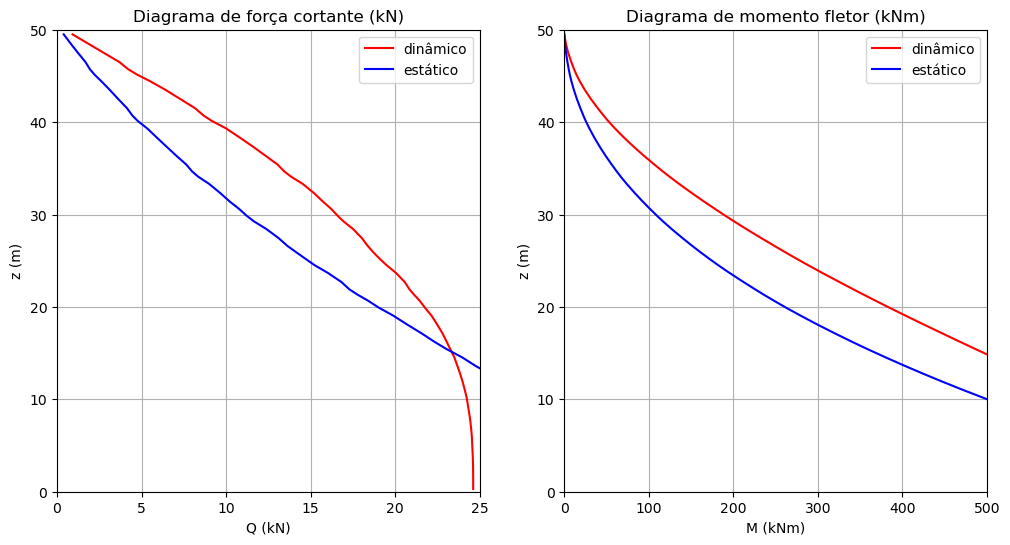

In [26]:
# Cortante é a integral da carga aplicada
Qeq1 = Feq1.cumsum()
QmT  = FmT.cumsum()

# Momento fletor é a integral do cortante
zdif = np.hstack((0, -np.diff(zm)))
Meq1 = np.cumsum(Qeq1*zdif)
MmT  = np.cumsum(QmT *zdif)

# Visualiza diagramas
plt.figure(8, figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(Qeq1/1000, zm, 'r')
plt.plot(QmT/1000,  zm, 'b')
plt.axis([0, 25, 0, H])
plt.title('Diagrama de força cortante (kN)')
plt.legend(('dinâmico','estático'), loc=1)
plt.xlabel('Q (kN)')
plt.ylabel('z (m)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Meq1/1000, zm, 'r')
plt.plot(MmT/1000,  zm, 'b')
plt.axis([0, 500, 0, H])
plt.title('Diagrama de momento fletor (kNm)')
plt.legend(('dinâmico','estático'), loc=1)
plt.xlabel('M (kNm)')
plt.ylabel('z (m)')
plt.grid(True)


Conclui-se que para esta torre em particular a análise dinâmica não é muito importante, acrescendo em pouco os esforços devido a efeitos ressonantes.


## 10 Referências <a name="section_10"></a> 


1. **Clough, R.W. and Penzien, J.**, _Dynamics of Structures_, 2nd ed.; McGraw-Hill, E.U.A., 1993.
2. **Blessmann, J.**, _O Vento na Engenharia Estrutural_; Editora da Universidade, UFRGS, Porto Alegre, 1995.
3. **Blessmann, J.**, _Introdução ao Estudo das Ações Dinâmicas do Vento_; Editora da Universidade, UFRGS, Porto Alegre, 1988.
4. **NBR-6123**, _Forças Devidas ao Vento em Edificações_; Associação Brasileira de Normas Técnicas, ABNT, Rio de Janeiro, 1988.
